<img align="right" src="tf-small.png"/>

# SBLGNT and Text-Fabric

The source of the SBLGNT data in TF is really a treebank, a hierarchical structure.
We converted an XML representation of it into TF.

The question of this notebook is: how to measure syntactic complexity of sentences by their tree structure,
and how is that complexity distributed over the text of the Greek New Testament.

This question is posed and dealt with by James Tauber: 
[Mean Dependency Depth](http://jktauber.com/2015/10/29/mean-dependency-depth/).
Here we examine a refined complexity measure that does not treat nesting chains as constructs
that increase complexity.

## Complexity
It is too simple to equate complexity with the depth of the syntax trees.
For example, the genealogy in Luke 3 has a depth of more than 100, but this is a *tail* embedding: after the 
embedded elements, the embedders do not resume.
Real complexity arises when embedders resume after embeddings at many levels.

<img align="left" src="Complexity.png" width="40%"/>

## Rank
The following definition tries to capture the notion of complexity by weeding out chains of nodes that all branch in the same direction. The intuition is that every such chain only counts for one in terms of depth.
Rather than ranking trees or paths within trees for complexity, we rank *nodes*. A node with high rank corresponds to 
a location in the tree that is deeply embedded, with lots of resumptions afterwards.
One could easily extend the concept of rank from nodes to paths or trees, by taking the maximum rank that occurs on a 
path or tree. 

1. The *rank* of the root node is 0.
1. The *rank* of *the* child of a unary branching node is the same as the rank of its parent.
1. If a node has rank 0, and that node is properly branching (more than one child), all its children have rank 1.
1. If a node $n$ has a positive rank $r$ and it has at least two children,
   it has a properly branching ancestor $p$ with rank $r-1$. (There is only one such $p$).
1. If the path from $p$ to $n$ did not start with a left-most or right-most child, then all children of $n$
   have rank $r+1$.
1. If the path from $p$ to $n$ started with a left-most child, then all children of $n$, except the left-most one,
   have rank $r+1$, and the left-most one has rank $r$.
1. If the path from $p$ to $n$ started with a right-most child, then all children of $n$, except the right-most one,
   have rank $r+1$, and the right-most one has rank $r$.
   
## Distribution
We will compute the rank of all terminal nodes in the GNT, and order them accordingly, and see how complexity is distributed over the books and chapters.

Here is an 
[Excel Sheet](complexity.xlsx) of all words with rank >= 10 (2721 words).
It has also sheets for complexity listings of books as a whole and chapters as a whole.

Below you see the complexity profile per book.

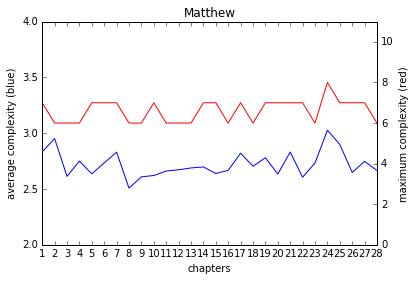

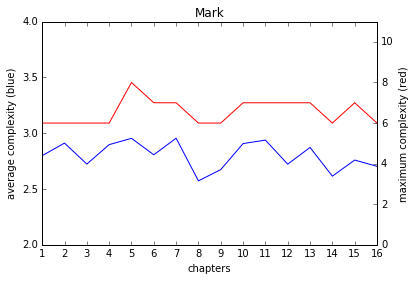

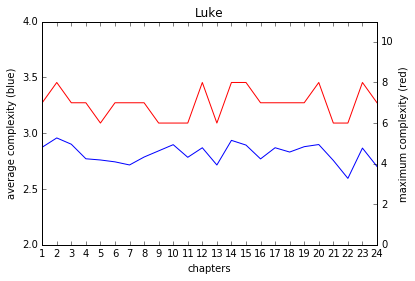

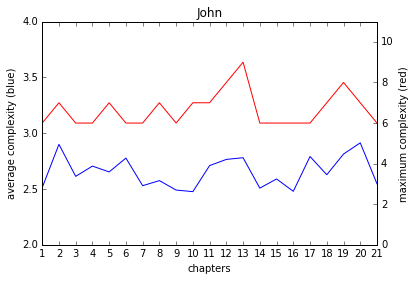

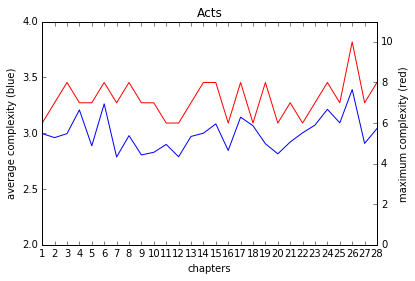

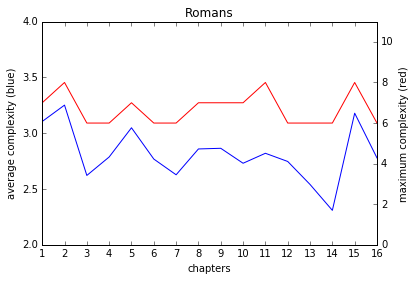

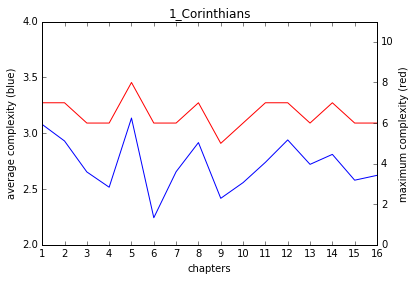

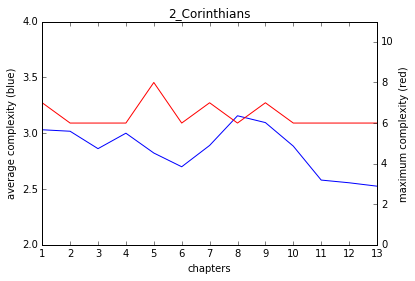

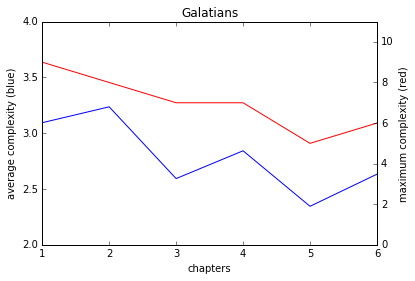

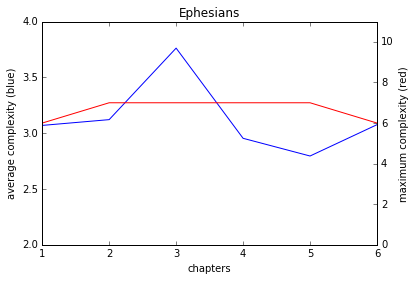

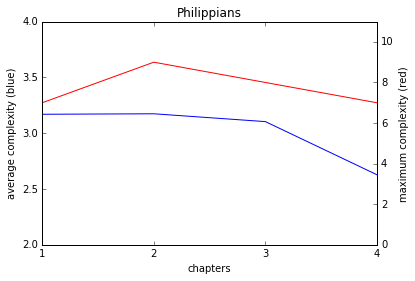

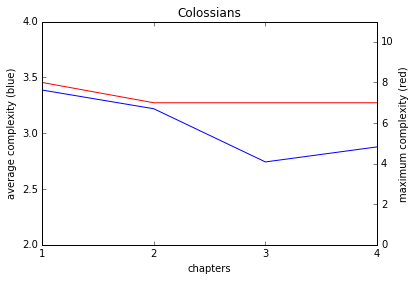

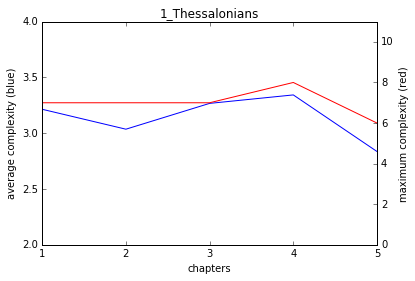

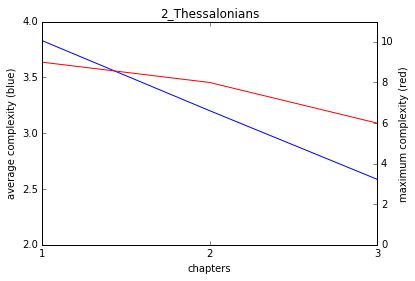

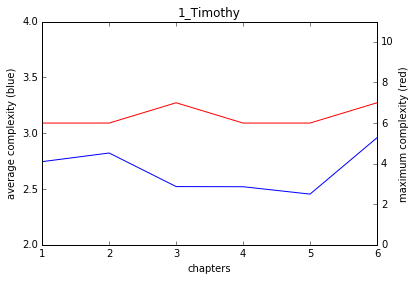

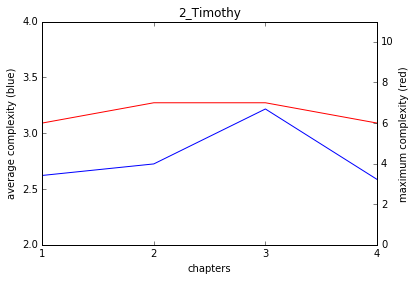

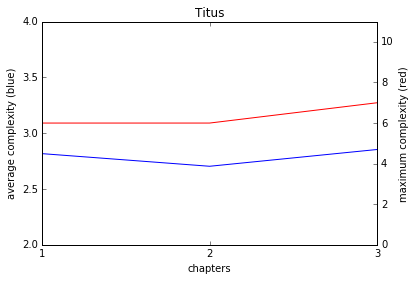

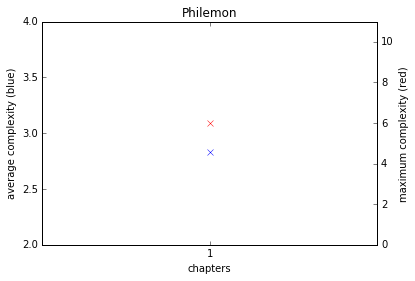

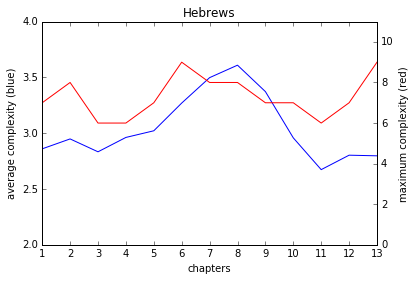

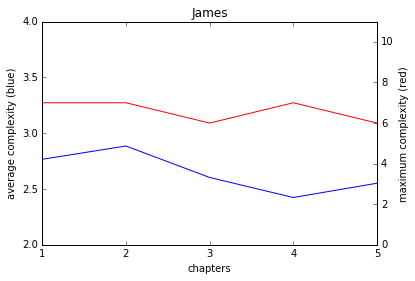

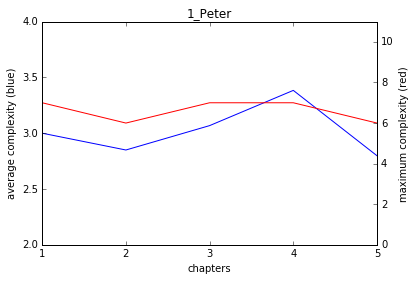

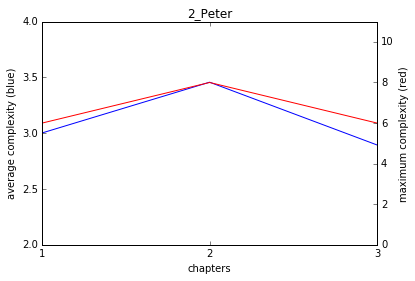

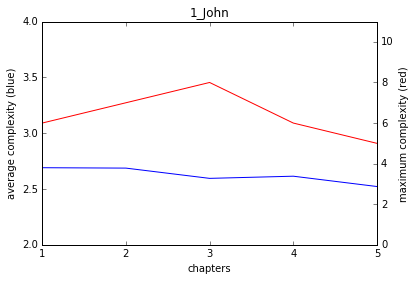

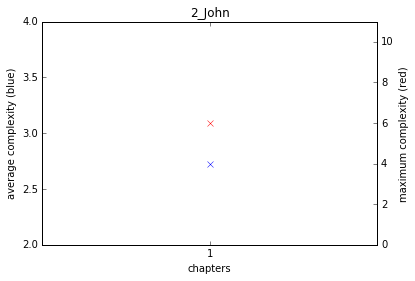

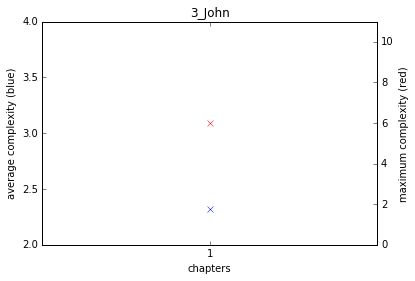

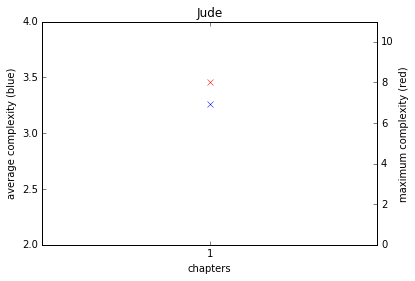

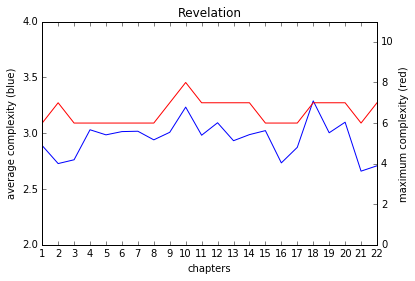

In [45]:
# run this cell later
for b in series: chart(b)

In [2]:
import os,collections,xlsxwriter
import matplotlib.pyplot as plt
%matplotlib inline
from tf.fabric import Fabric

In [3]:
TF = Fabric(modules='greek/sblgnt')

This is Text-Fabric 2.3.5
Api reference : https://github.com/ETCBC/text-fabric/wiki/Api
Tutorial      : https://github.com/ETCBC/text-fabric/blob/master/docs/tutorial.ipynb
Data sources  : https://github.com/ETCBC/text-fabric-data
Data docs     : https://etcbc.github.io/text-fabric-data
Shebanq docs  : https://shebanq.ancient-data.org/text
Slack team    : https://shebanq.slack.com/signup
Questions? Ask shebanq@ancient-data.org for an invite to Slack
60 features found and 0 ignored


In [4]:
api = TF.load('''
    Unicode
    book book@en chapter
    otype
    nodeId
    child
''')

api.makeAvailableIn(globals())

  0.00s loading features ...
   |     0.01s B otype                from /Users/dirk/github/text-fabric-data/greek/sblgnt
   |     0.00s B book                 from /Users/dirk/github/text-fabric-data/greek/sblgnt
   |     0.00s B chapter              from /Users/dirk/github/text-fabric-data/greek/sblgnt
   |     0.11s B Unicode              from /Users/dirk/github/text-fabric-data/greek/sblgnt
   |     0.00s B book@en              from /Users/dirk/github/text-fabric-data/greek/sblgnt
   |     0.17s B nodeId               from /Users/dirk/github/text-fabric-data/greek/sblgnt
   |     0.38s B child                from /Users/dirk/github/text-fabric-data/greek/sblgnt
   |     0.00s Feature overview: 57 for nodes; 2 for edges; 1 configs; 7 computed
  2.79s All features loaded/computed - for details use loadLog()


In [5]:
def computeRanks():
    for s in F.otype.s('sentence'):
        computeRankNodes(s, 0, 0)

def computeRankNodes(node, rank, branchType):
    children = E.child.f(node)
    if children == None or len(children) == 0:
        ranks[node] = rank
        return
    lc = len(children)
    if lc == 1:
        computeRankNodes(children[0], rank, branchType)
    else:
        for (i, c) in enumerate(children):
            newRank = rank + 1 if branchType == 0 or\
                                  (branchType == -1 and i > 0) or\
                                  (branchType == 1 and i < lc - 1)\
                               else rank
            newBranchType = -1 if i == 0 else 1 if i == lc - 1 else 0
            computeRankNodes(c, newRank, newBranchType)

In [6]:
indent(reset=True)
info('computing ranks ...')
ranks = dict()
computeRanks()
info('assigned ranks to {} terminals'.format(len(ranks)))

  0.00s computing ranks ...
  1.10s assigned ranks to 137794 terminals


# Distribution of ranks

In [7]:
rankCounter = collections.Counter()
for (n, r) in ranks.items(): rankCounter[r] += 1

for (r, ns) in sorted(rankCounter.items(), key=lambda x: x[0]):
    print('Rank {:>3}: {:>6} terminal{}'.format(r, ns, '' if ns == 1 else 's'))

Rank   0:      2 terminals
Rank   1:  17105 terminals
Rank   2:  46511 terminals
Rank   3:  32770 terminals
Rank   4:  29764 terminals
Rank   5:   7783 terminals
Rank   6:   3249 terminals
Rank   7:    495 terminals
Rank   8:    101 terminals
Rank   9:     13 terminals
Rank  10:      1 terminal


# Maximum and average rank per book

In [8]:
statsBook = []
statsChapter = []

for b in F.otype.s('book'):
    sumRank = 0
    maxRank = 0
    n = 0
    for w in L.d(b, 'word'):
        rank = ranks[w]
        if rank > maxRank: maxRank = rank
        sumRank += rank
        n += 1
    statsBook.append((Fs('book@en').v(b), sumRank / n, maxRank, n))

for c in F.otype.s('chapter'):
    sumRank = 0
    maxRank = 0
    n = 0
    for w in L.d(c, 'word'):
        rank = ranks[w]
        if rank > maxRank: maxRank = rank
        sumRank += rank
        n += 1
    (book, chapter, verse) = T.sectionFromNode(c)
    statsChapter.append((book, chapter, sumRank / n, maxRank, n))

sortedBooks = sorted(statsBook, key=lambda x: (-x[1], -x[2], x[0]))
print('BOOKS')
print('{:<18} {:>5} {:>2} {:>5}'.format('book', 'av', 'mx', '#words'))
for stat in sortedBooks:
    print('{:<18} {:>5.2f} {:>2} {:>5}'.format(*stat))

sortedChapters = sorted(statsChapter, key=lambda x: (-x[2], -x[3], x[0], x[1]))
limit = 50
print('\n{:<18}{:>2} {:>5} {:>2} {:>5}'.format('chapter', 'ch', 'av', 'mx', '#words'))

print('\nTop {} CHAPTERS'.format(limit))
for stat in sortedChapters[0:limit]:
    print('{:<18}{:>2} {:>5.2f} {:>2} {:>5}'.format(*stat))

print('\nBottom {} CHAPTERS'.format(limit))
for stat in sortedChapters[-limit:]:
    print('{:<18}{:>2} {:>5.2f} {:>2} {:>5}'.format(*stat))

BOOKS
book                  av mx #words
Jude                3.26  8   459
2_Thessalonians     3.18  9   820
2_Peter             3.12  8  1098
1_Thessalonians     3.12  8  1473
Colossians          3.10  8  1580
Ephesians           3.10  7  2416
Philippians         3.04  9  1626
Hebrews             3.03  9  4935
1_Peter             3.02  7  1678
Acts                2.98 10 18413
Revelation          2.94  8  9833
2_Corinthians       2.86  8  4473
Romans              2.84  8  7055
Philemon            2.84  6   334
Luke                2.81  8 19446
Galatians           2.81  9  2226
Titus               2.80  7   659
Mark                2.79  8 11286
2_Timothy           2.75  7  1256
2_John              2.73  6   245
Matthew             2.72  8 18329
1_Corinthians       2.70  8  6812
1_Timothy           2.68  7  1591
James               2.67  7  1770
John                2.66  9 15625
1_John              2.62  8  2137
3_John              2.32  6   219

chapter           ch    av mx #words

To

# Top ranks
We write out the top ranks in an Excel sheet.
First we make a list of rows out if the ranks dicitionary.

In [9]:
resultW = []
for (t, r) in sorted((x for x in ranks.items() if x[1] >= 6), key=lambda y: -y[1]):
    (book, chapter, verse) = T.sectionFromNode(t)
    resultW.append(dict(
        book=book,
        chapter=chapter,
        verse=verse,
        node=t,
        nodeId=F.nodeId.v(t),
        word=F.Unicode.v(t),
        rank=r,
    ))

resultC = []
for (book, chapter, av, mx, nw) in sortedChapters:
    resultC.append(dict(
        book=book,
        chapter=chapter,
        average=av,
        max=mx,
        words=nw,
    ))

resultB = []
for (book, av, mx, nw) in sortedBooks:
    resultB.append(dict(
        book=book,
        average=av,
        max=mx,
        words=nw,
    ))
    
print('Word    {} rows'.format(len(resultW)))
print('Chapter {} rows'.format(len(resultC)))
print('Book    {} rows'.format(len(resultB)))

Word    3859 rows
Chapter 260 rows
Book    27 rows


Then we write it to an excel sheet.

In [10]:
workbook = xlsxwriter.Workbook('complexity.xlsx', {'strings_to_urls': False})
worksheetW = workbook.add_worksheet('word')
worksheetC = workbook.add_worksheet('chapter')
worksheetB = workbook.add_worksheet('book')

greekFormat = workbook.add_format({'font_name': 'Times New Roman', 'font_size': 14})
codeFormat = workbook.add_format({'font_name': 'Courier New', 'font_size': 11})
smallFormat = workbook.add_format({'font_name': 'Arial', 'font_size': 10})
nodeFormat = workbook.add_format({'font_name': 'Arial', 'font_size': 9})
normalFormat = workbook.add_format({'font_name': 'Arial', 'font_size': 11})

# book chapter node nodeId word rank
fieldsW = '''
    book
    chapter
    verse
    node
    nodeId
    word
    rank
'''.strip().split()

fieldsC = '''
    book
    chapter
    average
    max
    words
'''.strip().split()

fieldsB = '''
    book
    average
    max
    words
'''.strip().split()


fieldSpecs = dict(
    book=(16, smallFormat),
    chapter=(3, smallFormat),
    verse=(3, smallFormat),
    node=(7, nodeFormat),
    nodeId=(20, codeFormat),
    word=(30, greekFormat),
    rank=(4, normalFormat),
    average=(4, normalFormat),
    max=(4, normalFormat),
    words=(10, normalFormat)
)

for (fields, worksheet, result) in (
    (fieldsW, worksheetW, resultW),
    (fieldsC, worksheetC, resultC),
    (fieldsB, worksheetB, resultB),
):
    fieldOrder = list(enumerate(fields))

    for (f, field) in fieldOrder:
        (width, fmt) = fieldSpecs[field]
        worksheet.set_column(f, f, width, fmt)

    for r in range(len(result)):
        worksheet.set_row(r, 24)

    for (f, field) in fieldOrder: worksheet.write(0, f, field)
    for (r, row) in enumerate(result):
        for (f, field) in fieldOrder:
            worksheet.write(r+1, f, row[field])
workbook.close()

# Pofiles of complexity per book
We create graphs of the average complexity per chapter for each book.

In [12]:
series = collections.OrderedDict()
for (book, chapter, av, mx, nw) in statsChapter:
    series.setdefault(book, []).append((chapter, av, mx))

In [46]:
def chart(book):
    chapters = series[book]
    chapterNames = [ch[0] for ch in chapters]
    chapterAv = [ch[1] for ch in chapters]
    chapterMax = [ch[2] for ch in chapters]
    style = '-' if len(chapters) > 1 else 'x'
    (start, end) = (0, len(chapterNames)-1) if len(chapters) > 1 else (-0.5, 0.5)

    x = range(len(chapterNames))
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    ax1.set_xlabel('chapters')
    plt.xticks(x, chapterNames)
    ax1.plot(x, chapterAv, 'b{}'.format(style))
    ax1.set_ylabel('average complexity (blue)')

    ax2 = ax1.twinx()
    ax2.plot(x, chapterMax, 'r{}'.format(style))
    ax2.set_ylabel('maximum complexity (red)')
    
    ax1.axis([start, end, 2, 4])
    ax2.axis([start, end, 0, 11])

    plt.title(book)
    plt.show()
    
# now you can run the cell at the top that produces the charts